## Análisis Exploratorio de Datos (EDA)

In [2]:
# Importar librerías necesarias
import pandas as pd
import sqlite3 as sql
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt

### Cargar datos

In [3]:
ruta_archivo = "../data/raw/adidas_us_sales_dataset.xlsx"
df = pd.read_excel(ruta_archivo, index_col=None)

# Eliminar columna de índice anterior si existe
if 'Unnamed: 0' in df.columns:
    df.drop(columns=['Unnamed: 0'], inplace=True)

# Guardar en SQLite
conn = sql.connect("../data/raw/adidas_sales.db")
df.to_sql("ventas_adidas", conn, if_exists="replace", index=False)

print("Base de datos creada con éxito")

cursor = conn.cursor()


Base de datos creada con éxito


## Tamaño del Dataset

In [4]:
df.shape

(9648, 13)

Tamaño del dataset: 9648 Filas y 13 columnas

In [5]:
# Información general de los datos
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9648 entries, 0 to 9647
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Retailer          9648 non-null   object        
 1   Retailer ID       9648 non-null   int64         
 2   Invoice Date      9648 non-null   datetime64[ns]
 3   Region            9648 non-null   object        
 4   State             9648 non-null   object        
 5   City              9648 non-null   object        
 6   Product           9648 non-null   object        
 7   Price per Unit    9648 non-null   float64       
 8   Units Sold        9648 non-null   int64         
 9   Total Sales       9648 non-null   float64       
 10  Operating Profit  9648 non-null   float64       
 11  Operating Margin  9648 non-null   float64       
 12  Sales Method      9648 non-null   object        
dtypes: datetime64[ns](1), float64(4), int64(2), object(6)
memory usage: 980.0+ KB


## Tipos de variables detectadas

In [6]:
# Tipos de datos
df.dtypes

Retailer                    object
Retailer ID                  int64
Invoice Date        datetime64[ns]
Region                      object
State                       object
City                        object
Product                     object
Price per Unit             float64
Units Sold                   int64
Total Sales                float64
Operating Profit           float64
Operating Margin           float64
Sales Method                object
dtype: object

#### Numéricas:

- Retailer ID
- Price per Unit
- Units Sold
- Total Sales
- Operating Profit
- Operating Margin

#### Categóricas:

- Retailer
- Region
- State
- City
- Product
- Sales Method

#### Fechas:

- Invoice Date

## Exploración Inicial y calidad de datos:

### Columnas con valores nulos:

In [7]:
valores_nulos = """
                SELECT
                    SUM(CASE WHEN Retailer IS NULL THEN 1 ELSE 0 END) AS retailer_nulos,
                    SUM(CASE WHEN `Retailer ID` IS NULL THEN 1 ELSE 0 END) AS retailerid_nulos,
                    SUM(CASE WHEN `Invoice Date` IS NULL THEN 1 ELSE 0 END) AS invoice_date_nulos,
                    SUM(CASE WHEN Region IS NULL THEN 1 ELSE 0 END) AS region_nulos,
                    SUM(CASE WHEN State IS NULL THEN 1 ELSE 0 END) AS state_nulos,
                    SUM(CASE WHEN City IS NULL THEN 1 ELSE 0 END) AS city_nulos,
                    SUM(CASE WHEN Product IS NULL THEN 1 ELSE 0 END) AS products_nulos,
                    SUM(CASE WHEN `Price per Unit` IS NULL THEN 1 ELSE 0 END) AS price_per_unit_nulos,
                    SUM(CASE WHEN `Units Sold` IS NULL THEN 1 ELSE 0 END) AS units_sold_nulos,
                    SUM(CASE WHEN `Total Sales` IS NULL THEN 1 ELSE 0 END) AS total_sales_nulos,
                    SUM(CASE WHEN `Operating Profit` IS NULL THEN 1 ELSE 0 END) AS operating_profit_nulos,
                    SUM(CASE WHEN `Operating Margin` IS NULL THEN 1 ELSE 0 END) AS operating_margin_nulos,
                    SUM(CASE WHEN `Sales Method` IS NULL THEN 1 ELSE 0 END) AS sales_methond_nulos
                FROM ventas_adidas;
                """
valores_nulos = pd.read_sql_query(valores_nulos, conn)
valores_nulos

,retailer_nulos,retailerid_nulos,invoice_date_nulos,region_nulos,state_nulos,city_nulos,products_nulos,price_per_unit_nulos,units_sold_nulos,total_sales_nulos,operating_profit_nulos,operating_margin_nulos,sales_methond_nulos
0,0,0,0,0,0,0,0,0,0,0,0,0,0


En conclusión no hay valores nulos

### Registros duplicados

In [8]:
consulta = """
            WITH duplicados AS (
                SELECT *,
                    ROW_NUMBER() OVER (
                        PARTITION BY `Retailer ID`, `Invoice Date`, Product, `Sales Method`, City, State, `Price per Unit`
                        ORDER BY `Units Sold` DESC
                    ) AS num_fila
                FROM ventas_adidas
            )
            SELECT *
            FROM duplicados
            WHERE num_fila = 2;
            """
duplicados = pd.read_sql_query(consulta, conn)
duplicados

,Retailer,Retailer ID,Invoice Date,Region,State,City,Product,Price per Unit,Units Sold,Total Sales,Operating Profit,Operating Margin,Sales Method,num_fila
0,West Gear,1185732,1969-12-31 19:00:43.945000,Southeast,Florida,Miami,Men's Athletic Footwear,55.0,775,426250.0,149187.5,0.35,In-store,2
1,West Gear,1185732,1969-12-31 19:00:43.945000,Southeast,Florida,Miami,Men's Athletic Footwear,54.0,194,10476.0,5238.0,0.50,Online,2
2,Foot Locker,1185732,1969-12-31 19:00:44.245000,South,Mississippi,Jackson,Women's Athletic Footwear,25.0,91,2275.0,1137.5,0.50,Online,2
3,Sports Direct,1185732,1969-12-31 19:00:44.263000,Midwest,North Dakota,Fargo,Women's Athletic Footwear,25.0,22,550.0,231.0,0.42,Online,2
4,Amazon,1185732,1969-12-31 19:00:44.264000,Midwest,Ohio,Columbus,Women's Street Footwear,20.0,124,2480.0,1314.4,0.53,Online,2
5,Sports Direct,1185732,1969-12-31 19:00:44.289000,Southeast,North Carolina,Charlotte,Women's Street Footwear,20.0,144,2880.0,1584.0,0.55,Online,2
6,Kohl's,1197831,1969-12-31 19:00:44.241000,Midwest,Kansas,Wichita,Women's Athletic Footwear,20.0,42,840.0,378.0,0.45,Online,2
7,Kohl's,1197831,1969-12-31 19:00:44.267000,Midwest,Kansas,Wichita,Men's Street Footwear,20.0,153,3060.0,1499.4,0.49,Online,2
8,Kohl's,1197831,1969-12-31 19:00:44.267000,Midwest,Kansas,Wichita,Women's Athletic Footwear,20.0,26,520.0,249.6,0.48,Online,2
9,Walmart,1197831,1969-12-31 19:00:44.274000,South,Arkansas,Little Rock,Men's Athletic Footwear,20.0,98,1960.0,882.0,0.45,Online,2


In [9]:
consulta = """
            SELECT DISTINCT `Retailer ID`, `Invoice Date`, Product, `Sales Method`, City, State, `Price per Unit`
            FROM ventas_adidas;
           """
valores_distintos = pd.read_sql_query(consulta, conn)
valores_distintos

,Retailer ID,Invoice Date,Product,Sales Method,City,State,Price per Unit
0,1185732,1969-12-31 19:00:43.831000,Men's Street Footwear,In-store,New York,New York,50.0
1,1185732,1969-12-31 19:00:43.832000,Men's Athletic Footwear,In-store,New York,New York,50.0
2,1185732,1969-12-31 19:00:43.833000,Women's Street Footwear,In-store,New York,New York,40.0
3,1185732,1969-12-31 19:00:43.834000,Women's Athletic Footwear,In-store,New York,New York,45.0
4,1185732,1969-12-31 19:00:43.835000,Men's Apparel,In-store,New York,New York,60.0
...,...,...,...,...,...,...,...
9629,1185732,1969-12-31 19:00:44.220000,Men's Apparel,Outlet,Manchester,New Hampshire,50.0
9630,1185732,1969-12-31 19:00:44.220000,Women's Apparel,Outlet,Manchester,New Hampshire,41.0
9631,1185732,1969-12-31 19:00:44.249000,Men's Street Footwear,Outlet,Manchester,New Hampshire,41.0
9632,1185732,1969-12-31 19:00:44.249000,Men's Athletic Footwear,Outlet,Manchester,New Hampshire,42.0


En conclusión hay 13 registros duplicados

### Formatos Inconsistentes:

- Ninguno

### Valores Atípicos (Outliers)

Columnas a usar:

- Region
- City
- Product
- Price per Unit
- Units Sold
- Total Sales
- Sales Method

#### Outliers en Datos Categóricos

In [24]:
query = """
        SELECT Region, COUNT(*)
        FROM ventas_adidas
        GROUP BY Region
        ORDER BY COUNT(*) ASC;
        """
outliers_dc = pd.read_sql_query(query, conn)
outliers_dc

,Region,COUNT(*)
0,Southeast,1224
1,South,1728
2,Midwest,1872
3,Northeast,2376
4,West,2448


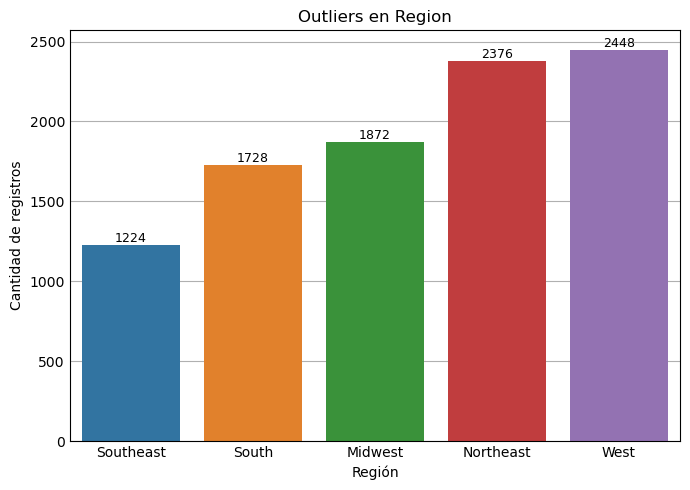

In [42]:
plt.figure(figsize=(7, 5))
ax = sns.barplot(data=outliers_dc, x='Region', y='COUNT(*)', palette='tab10')

# Añadir los valores encima de cada barra
for p in ax.patches:
    altura = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2,     # posición x: centro de la barra
            altura + 1,                        # posición y: un poco arriba del borde
            int(altura),                       # valor a mostrar
            ha='center', va='bottom', fontsize=9)

# Títulos y etiquetas
plt.title('Outliers en Region')
plt.xlabel('Región')
plt.ylabel('Cantidad de registros')
plt.tight_layout()
plt.show()




- No hay outliers en la columna Region

In [53]:
query = """
        SELECT City, COUNT(*)
        FROM ventas_adidas
        GROUP BY City
        ORDER BY COUNT(*) ASC
        LIMIT 5;
        """
outliers_dc = pd.read_sql_query(query, conn)
outliers_dc

,City,COUNT(*)
0,Albany,144
1,Anchorage,144
2,Baltimore,144
3,Billings,144
4,Charlotte,144


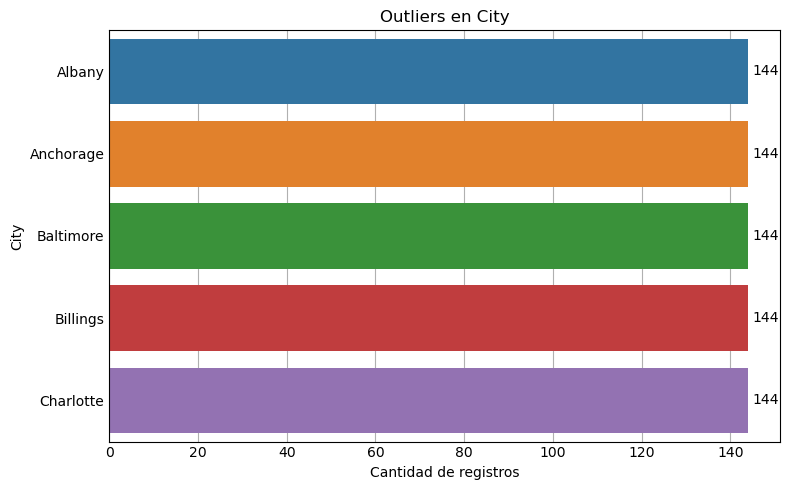

In [ ]:
plt.figure(figsize=(8, 5))
ax = sns.barplot(data=outliers_dc, x='COUNT(*)', y='City', palette='tab10')

# Añadir valores al final de cada barra
for p in ax.patches:
    ancho = p.get_width()
    ax.text(ancho + 1,                           # posición x (ligeramente a la derecha)
            p.get_y() + p.get_height() / 2,     # posición y (centro de la barra)
            int(ancho),                         # valor a mostrar
            va='center')                        # alineación vertical

plt.title('Outliers en City')
plt.xlabel('Cantidad de registros')
plt.ylabel('City')
plt.tight_layout()
plt.show()

- No hay outliers en la columna City

In [63]:
query = """
        SELECT Product, COUNT(*)
        FROM ventas_adidas
        GROUP BY Product
        ORDER BY COUNT(*) ASC;
        """
outliers_dc = pd.read_sql_query(query, conn)
outliers_dc

,Product,COUNT(*)
0,Men's Apparel,1606
1,Women's Athletic Footwear,1606
2,Women's Apparel,1608
3,Women's Street Footwear,1608
4,Men's Athletic Footwear,1610
5,Men's Street Footwear,1610


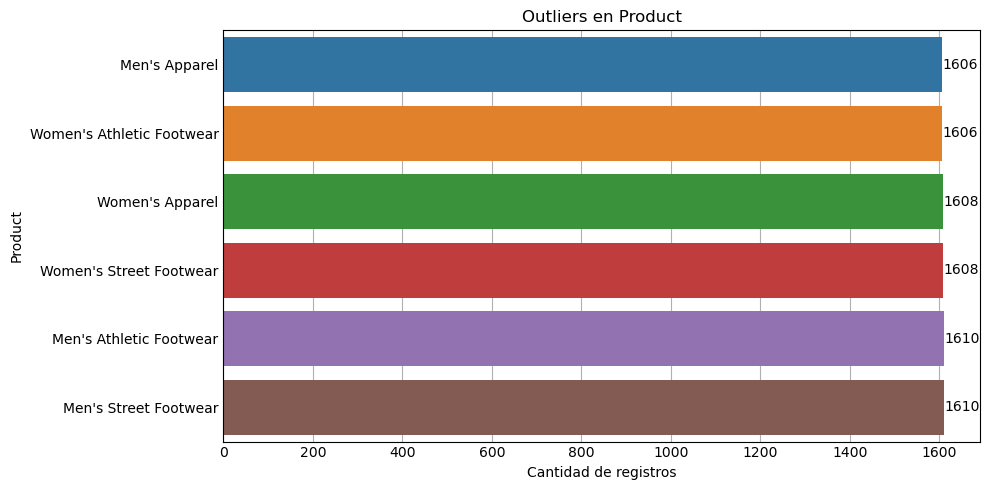

In [66]:
plt.figure(figsize=(10, 5))
ax = sns.barplot(data=outliers_dc, y='Product', x='COUNT(*)', palette='tab10')

# Añadir valores al final de cada barra
for p in ax.patches:
    ancho = p.get_width()
    ax.text(ancho + 1,                           # posición x (ligeramente a la derecha)
            p.get_y() + p.get_height() / 2,     # posición y (centro de la barra)
            int(ancho),                         # valor a mostrar
            va='center')                        # alineación vertical
    
plt.title('Outliers en Product')
plt.xlabel('Cantidad de registros')
plt.ylabel('Product')
plt.tight_layout()
plt.show()

- No hay outliers en la columna Product

#### Outliers en Datos Numéricos

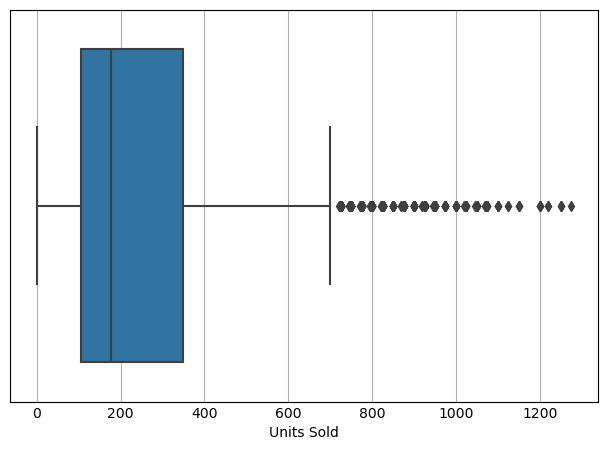

In [68]:
plt.figure(figsize=(6, 4))

sns.boxplot(x=df['Units Sold'])
plt.show()

In [15]:
# Valores atípicos con desviación estandar
def atp_ds(lista):
    arr = np.array(lista)
    media = np.mean(arr)
    desv_std = np.std(arr, ddof=1) # ddof=1 para datos muestrales en lugar de poblacionales
    # Definir umbrales para outliers (usamos 3 desviaciones estándar)
    limite_inferior = media - (3 * desv_std)
    limite_superior = media + (3 * desv_std)
    # Identificar outliers
    outliers = [x for x in arr if x < limite_inferior or x > limite_superior]
    cantidad_outliers = 0
    for i in outliers:
        cantidad_outliers += 1
    print(f" La media o promedio : {media}")
    print(f" La desviación estándar muestral : {desv_std}")
    print(f" El límite inferior : {limite_inferior}")
    print(f" El límite superior : {limite_superior}")
    print(f" La cantidad de outliers detectados: {cantidad_outliers}")
    print(f" Los Outliers detectados: {outliers}")


# Valores atípicos usando IQR
def out_iqr(lista):
    arr = np.array(lista)
    Q1 = np.percentile(arr, 25)
    Q3 = np.percentile(arr, 75)
    IQR = Q3 - Q1
    
    limite_inferior = Q1 - 1.5 * IQR
    limite_superior = Q3 + 1.5 * IQR
    
    outliers = arr[(arr < limite_inferior) | (arr > limite_superior)]
    cantidad_outliers = 0
    for i in outliers:
        cantidad_outliers += 1
    print("Q1:", Q1)
    print("Q3:", Q3)
    print("IQR:", IQR)
    print(f"Límite inferior : {limite_inferior}")
    print(f"Límite superior : {limite_superior}")
    print(f"La cantidad de outliers: {cantidad_outliers}")
    print("Outliers detectados:", ", ".join(map(str, outliers)))  # Outliers separados por comas